In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import logging
logging.root.setLevel(10)
import seaborn as sns; sns.set_theme()

import sys
import json
import os
sys.path.insert(0, os.path.realpath('..'))
os.chdir('..')

from src import data
from src.model import get_splits
with open('config.json', 'r') as cfg:
    config = json.load(cfg)
    
random_seed = 42

In [2]:
#!pip install tueplots
from tueplots import bundles
# global change:
plt.rcParams.update(bundles.neurips2021(usetex=False))

In [3]:
def get_country_name(code):
    country = pycountry.countries.get(alpha_3=code)
    return country.name if country else None


def load_data(config, get_top_level_categories=False):
    return_columns = [
        "Country code", "Country", "Function code", "Function", "Year",
        'Percentage of total expenditure', 'Total expenditure per capita (1000s USD)',
        'Expenditure per capita (1000s USD)', 'Happiness score',
    ]
    data_path = config["data_location"]
    cofog = pd.read_csv(data_path + config["cofog_dataset"])
    happiness = pd.read_csv(data_path + config["happiness_dataset"], sep=';')
    total_spending = pd.read_csv(data_path + config["total_spending_dataset"])

    # Normalize OECD data to percentages of total instead of millions

    cofog.rename(columns={
        "LOCATION": "Country code",
        "ACTIVITY": "Function code"
    }, inplace=True)
    if get_top_level_categories:
        cofog = cofog[cofog["Function code"].str.len() == 3]
    else:
        cofog = cofog[cofog["Function code"].str.len() > 3]

    # Clean-up - null negative expenditures before, which don't make sense, before summing
    cofog.loc[cofog['Value'] < 0, 'Value'] = 0
    totals = cofog.groupby(["Country", "Year"], as_index=False)["Value"].sum()

    cofog = pd.merge(cofog, totals, on=["Country", "Year"])
    cofog = cofog.rename(columns={"Value_x": "Value", "Value_y": "Total expenditure"})
    cofog["Percentage of total expenditure"] = cofog["Value"]/cofog["Total expenditure"]

    # Calculate expenditure per capita in 1000s of USD
    total_spending["Country"] = total_spending["LOCATION"].apply(get_country_name)
    total_spending = total_spending.rename(columns={"TIME": "Year"})
    cofog_merged = pd.merge(cofog, total_spending[["Country", "Year", "Value"]], on=["Country", "Year"])
    cofog_merged = cofog_merged.rename(columns={"Value_y": "Total expenditure per capita (1000s USD)"})
    cofog_merged["Expenditure per capita (1000s USD)"] = \
        cofog_merged["Percentage of total expenditure"]*cofog_merged["Total expenditure per capita (1000s USD)"]

    # Merge in happiness scores
    happiness = happiness.rename(columns={"Country name": "Country", "year": "Year", "Life Ladder": "Happiness score"})
    happiness["Happiness score"] = pd.to_numeric(happiness["Happiness score"].str.replace(',', '.'))
    return pd.merge(cofog_merged, happiness, on=["Country", "Year"])[return_columns]


def filter_bad_data(data):
    essential_columns = ["Year", "Total expenditure per capita (1000s USD)", "Happiness score"]
    non_negative_columns = ['Percentage of total expenditure', 'Expenditure per capita (1000s USD)']

    data_rows_cnt = len(data.index)
    data.dropna(inplace=True)
    logging.info("Dropped {n} rows with NaN values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data != "").any(axis=1)]
    logging.info("Dropped {n} rows with empty string values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data[essential_columns] > 0).any(axis=1)]
    logging.info("Dropped {n} rows with invalid essential columns".format(n=data_rows_cnt - len(data.index)))

    assert not data.isnull().any().any()
    assert not (data == "").any().any()
    assert not (data[essential_columns] <= 0).any().any()
    return data


def create_samples(data):
    """Transforms data into samples with expenditures for each function as a column

    Return a tuple - first element has 'Percentage of total expenditure' as features values, second has
    'Expenditure per capita (1000s USD).'"""
    def make_samples(value_column):
        # Make Function Code values into columns
        pivoted = data.pivot(index=['Country', 'Year'], columns=['Function code'], values=[value_column])

        # Clean up structure
        pivoted.columns = pivoted.columns.get_level_values(1)
        pivoted = pivoted.reset_index()
        pivoted.columns.name = None

        # Missing Country, Year, Function code combinations get nulled
        pivoted = pivoted.where(~pivoted.isnull(), 0)

        return pd.merge(pivoted, data[
            ['Country', 'Year', 'Total expenditure per capita (1000s USD)', 'Happiness score']
        ].drop_duplicates(), on=['Country', 'Year'])

    return make_samples('Percentage of total expenditure'), make_samples('Expenditure per capita (1000s USD)')



In [4]:
whole_data = load_data(config)
whole_data = filter_bad_data(whole_data)
print(whole_data)

INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns


      Country code    Country Function code  \
0              AUT    Austria          0101   
1              AUT    Austria          0201   
2              AUT    Austria          0301   
3              AUT    Austria          0401   
4              AUT    Austria          0501   
...            ...        ...           ...   
22106          AUS  Australia          0408   
22107          AUS  Australia          0908   
22108          AUS  Australia          1008   
22109          AUS  Australia          0409   
22110          AUS  Australia          1009   

                                                Function  Year  \
0      Executive and legislative organs, financial, f...  2008   
1                                       Military defence  2008   
2                                        Police services  2008   
3        General economic, commercial and labour affairs  2008   
4                                       Waste management  2008   
...                                    

In [5]:
# heat map of the expenditure of each main category per capita
top_dataset = data.load_data(config, True)
top_clean_data = data.filter_bad_data(top_dataset)
top_samples = data.create_samples(top_clean_data)



INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns


<ipython-input-11-c634add58955>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(x, rotation=90, ha='right')
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000106.ax000107, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal 400 normal>) = 11.05
D

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Ahom' (NotoSerifAhom-Regular.ttf) nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Elbasan' (NotoSansElbasan-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplot

DEBUG:matplotlib._constrained_layout:bbox.y0 0.801778
DEBUG:matplotlib._constrained_layout:pos.y0 0.816017
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000108.ax000109, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.057574
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.014834
DEBUG:matplotlib._constrained_layout:bbox.y0 0.724998
DEBUG:matplotlib._constrained_layout:pos.y0 0.739237
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000110.ax000111, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.057574
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.014834
DEBUG:matplotlib._constrained_layout:bbox.y0 0.648218
DEBUG:matplotlib._constrained_layout:pos.y0 0.662458
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000112.ax000113, (left: 0.00

DEBUG:matplotlib._constrained_layout:bottom 0.014834
DEBUG:matplotlib._constrained_layout:bbox.y0 0.200122
DEBUG:matplotlib._constrained_layout:pos.y0 0.214361
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000122.ax000123, (left: 0.005) (bot: 0.100) (right: 1.000) (top: 0.198)
DEBUG:matplotlib._constrained_layout:left 0.057574
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.014834
DEBUG:matplotlib._constrained_layout:bbox.y0 0.100370
DEBUG:matplotlib._constrained_layout:pos.y0 0.114609
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000124.ax000125, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 0.098)
DEBUG:matplotlib._constrained_layout:left 0.062978
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.014834
DEBUG:matplotlib._constrained_layout:bbox.y0 0.000595
DEBUG:matplotlib._constrained_layout:pos.y0 0.014834
DEBUG:matplotlib.backends.backend_pdf:As

DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.200120
DEBUG:matplotlib._constrained_layout:pos.y0 0.214555
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000122.ax000123, (left: 0.005) (bot: 0.100) (right: 1.000) (top: 0.198)
DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.100358
DEBUG:matplotlib._constrained_layout:pos.y0 0.114792
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000124.ax000125, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 0.098)
DEBUG:matplotlib._constrained_layout:left 0.062327
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0

DEBUG:matplotlib._constrained_layout:bbox.y0 0.201918
DEBUG:matplotlib._constrained_layout:pos.y0 0.216353
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000122.ax000123, (left: 0.005) (bot: 0.102) (right: 1.000) (top: 0.199)
DEBUG:matplotlib._constrained_layout:left 0.056945
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.102380
DEBUG:matplotlib._constrained_layout:pos.y0 0.116815
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000124.ax000125, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 0.100)
DEBUG:matplotlib._constrained_layout:left 0.062327
DEBUG:matplotlib._constrained_layout:right 0.004167
DEBUG:matplotlib._constrained_layout:bottom 0.015030
DEBUG:matplotlib._constrained_layout:bbox.y0 0.000595
DEBUG:matplotlib._constrained_layout:pos.y0 0.015030
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:Layo

DEBUG:matplotlib._constrained_layout:left 0.056849
DEBUG:matplotlib._constrained_layout:right 0.004071
DEBUG:matplotlib._constrained_layout:bottom 0.015028
DEBUG:matplotlib._constrained_layout:bbox.y0 0.100358
DEBUG:matplotlib._constrained_layout:pos.y0 0.114792
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000105.ss000124.ax000125, (left: 0.000) (bot: 0.000) (right: 1.000) (top: 0.098)
DEBUG:matplotlib._constrained_layout:left 0.062231
DEBUG:matplotlib._constrained_layout:right 0.004071
DEBUG:matplotlib._constrained_layout:bottom 0.015028
DEBUG:matplotlib._constrained_layout:bbox.y0 0.000595
DEBUG:matplotlib._constrained_layout:pos.y0 0.015029


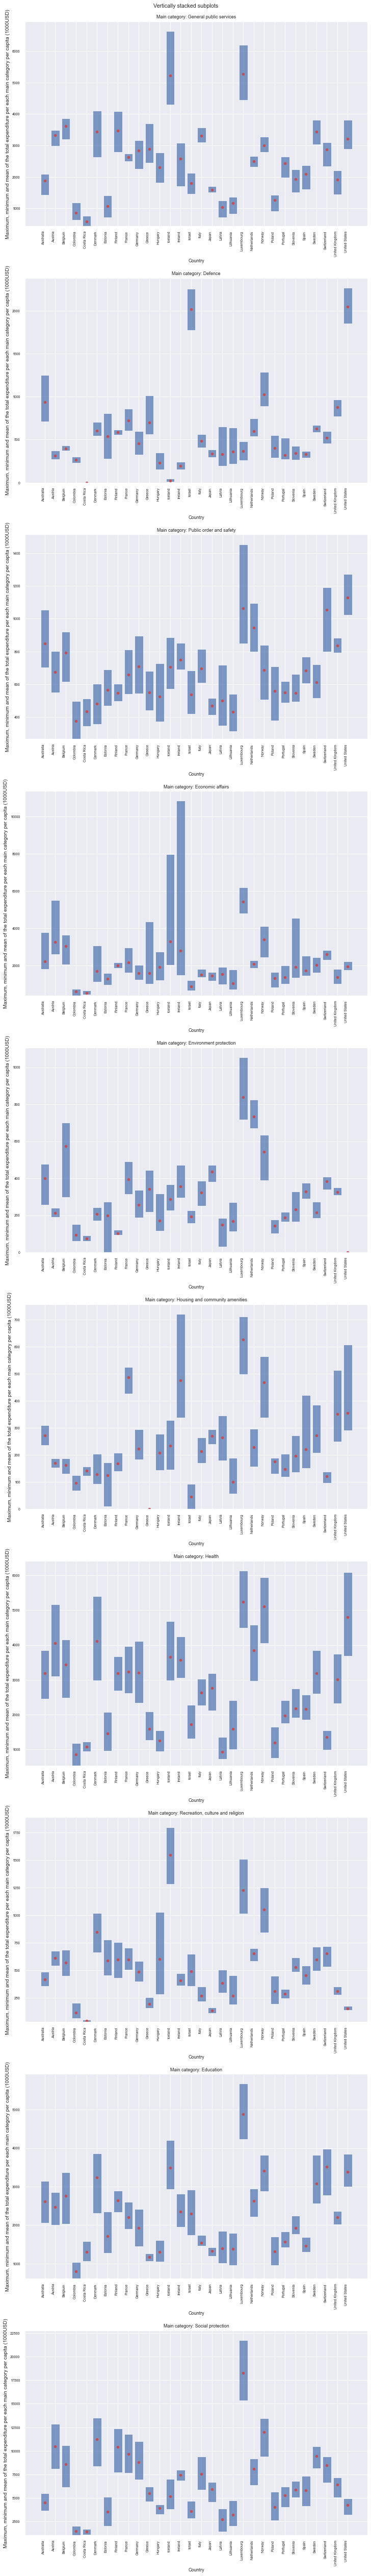

In [11]:
whole_data_box = top_samples[1]
# plot of maximum, minimum and mean of the total expenditure of each country, each main category per capita 
parent_data = data.load_data(config, True)

parent_code_mapping = parent_data.groupby(['Function code', 'Function'], as_index=False).sum()[['Function code', 'Function']]
name_main_category = parent_code_mapping["Function"].tolist()

list_main_category = ["010", "020", "030", "040", "050", "060", "070", "080", "090", "100"]
fig, axs = plt.subplots(10,figsize=(10, 70))
fig.suptitle('Vertically stacked subplots')
plt.xticks(rotation='vertical')
x = whole_data_box['Country'].unique()

for i, main_category in enumerate(list_main_category):
    bar_mean = whole_data_box.groupby(['Country'], as_index=False)[main_category].mean()
    bar_mean = bar_mean[main_category].tolist()
    bar_min = whole_data_box.groupby(['Country'], as_index=False)[main_category].min()
    bar_min = bar_min[main_category].tolist()
    bar_max = whole_data_box.groupby(['Country'], as_index=False)[main_category].max()
    bar_max = bar_max[main_category].tolist()
    array1 = np.array(bar_max)
    array2 = np.array(bar_min)
    subtracted_array = np.subtract(array1, array2)
    subtracted = list(subtracted_array)
    axs[i].set_xticklabels(x, rotation=90, ha='right')
    axs[i].bar(x, subtracted, width=0.8, bottom=bar_min, alpha=0.7, zorder = 1)
    axs[i].scatter(x, bar_mean,s = 20,  c = "r", zorder = 2)
    axs[i].set_xlabel("Country")
    axs[i].set_ylabel("Maximum, minimum and mean of the total expenditure per each main category per capita (1000USD)", fontsize = 10)
    axs[i].set_title("Main category: %s" %(name_main_category[i]) )

plt.savefig('Bar_plot_each_category.pdf')